# TD学習

TD (Temporal difference) learningにおいて，**報酬予測誤差**(reward prediction error, **RPE**) $\δ_{i}$は次のように計算される． 

$$ 
\begin{equation}
\δ_{i}=r+\gamma V_{j}\left(x^{\prime}\right)-V_{i}(x) 
\end{equation}
$$ 

ただし，現在の状態を$x$, 次の状態を$x'$, 予測価値分布を$V(x)$, 報酬信号を$r$, 時間割引率(time discount)を$\gamma$としました．
また，$V_{j}\left(x^{\prime}\right)$は予測価値分布$V\left(x^{\prime}\right)$からのサンプルです． このRPEは脳内において主に中脳の**VTA**(腹側被蓋野)や**SNc**(黒質緻密部)における**ドパミン(dopamine)ニューロン**の発火率として表現されています．

ただし，VTAとSNcのドパミンニューロンの役割は同一ではありません．ドパミンニューロンへの入力が異なっています [(Watabe-Uchida et al., _Neuron._ 2012)](https://www.cell.com/neuron/fulltext/S0896-6273(12)00281-4)． また，細かいですがドパミンニューロンの発火は報酬量に対して線形ではなく，やや飽和する非線形な応答関数 (Hill functionで近似可能)を持ちます([Eshel et al., _Nat. Neurosci._ 2016](https://www.nature.com/articles/nn.4239))．このため著者実装では報酬 $r$に非線形関数がかかっているものもあります．

先ほどRPEはドパミンニューロンの発火率で表現されている，といいました．RPEが正の場合はドパミンニューロンの発火で表現できますが，単純に考えると負の発火率というものはないため，負のRPEは表現できないように思います．ではどうしているかというと，RPEが0（予想通りの報酬が得られた場合）でもドパミンニューロンは発火しており，RPEが正の場合にはベースラインよりも発火率が上がるようになっています．逆にRPEが負の場合にはベースラインよりも発火率が減少する(抑制される)ようになっています
    ([Schultz et al., <span style="font-style: italic;">Science.</span> 1997](https://science.sciencemag.org/content/275/5306/1593.long "https://science.sciencemag.org/content/275/5306/1593.long"); [Chang et al., <span style="font-style: italic;">Nat Neurosci</span>. 2016](https://www.nature.com/articles/nn.4191 "https://www.nature.com/articles/nn.4191"))．発火率というのを言い換えればISI (inter-spike interval, 発火間隔)の長さによってPREが符号化されている(ISIが短いと正のRPE, ISIが長いと負のRPEを表現)ともいえます ([Bayer et al., <span style="font-style: italic;">J.
    Neurophysiol</span>. 2007](https://www.physiology.org/doi/full/10.1152/jn.01140.2006 "https://www.physiology.org/doi/full/10.1152/jn.01140.2006"))．

予測価値(分布) $V(x)$ですが，これは線条体(striatum)のパッチ (SNcに抑制性の投射をする)やVTAのGABAニューロン (VTAのドパミンニューロンに投射して減算抑制をする, ([Eshel, et al., _Nature_. 2015](https://www.nature.com/articles/nature14855 "https://www.nature.com/articles/nature14855")))などにおいて表現されている． この予測価値は通常のTD learningでは次式により更新されます． 

$$ 
\begin{equation}
V_{i}(x) \leftarrow V_{i}(x)+\alpha_{i} f\left(\δ_{i}\right) 
\end{equation}
$$ 

ただし，$\alpha_{i}$は学習率(learning rate), $f(\cdot)$はRPEに対する応答関数である．生理学的には$f(\δ)=\δ$を使うのが妥当である．

TD誤差

$$
\begin{equation}
\δ_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}
$$

価値の更新

$$
\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \δ_{t}
\end{equation}
$$

([Schultz, Dayan & Montague, Science, 1997](https://science.sciencemag.org/content/275/5306/1593))を参考にシミュレーションを行う．60試行する．0秒の時に条件刺激(光刺激)が入る．また，6試行目から40試行目まで条件刺激があってから1.2秒後に報酬が与えられるとする．

In [1]:
using LinearAlgebra, Random, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial")

In [5]:
num_trial = 60 # 試行回数
T = 3.0f0 # s
dt = 0.1f0 # s
nt = UInt(T/dt) + 1 # number of timesteps
value = zeros(num_trial, nt) 
δ = zeros(num_trial, nt) # TD error

flash_time = UInt(1.1f0/dt)
delay = UInt(1.2f0/dt)
reward_trial = 6:40 # 報酬が貰える試行の区間を設定する
reward = zeros(num_trial, nt)
reward[reward_trial, flash_time+delay] .= 1.0

α = 0.8 # 学習率
γ = 0.99 # 割引率

# simulation
for i in 2:num_trial
    for t in 1:nt-1
        δ[i, t] = reward[i, t] + γ*value[i-1, t+1] - value[i-1, t]
        if t > flash_time
            value[i, t] = value[i-1, t] + α*δ[i, t]
        end
    end
end

結果を描画する．

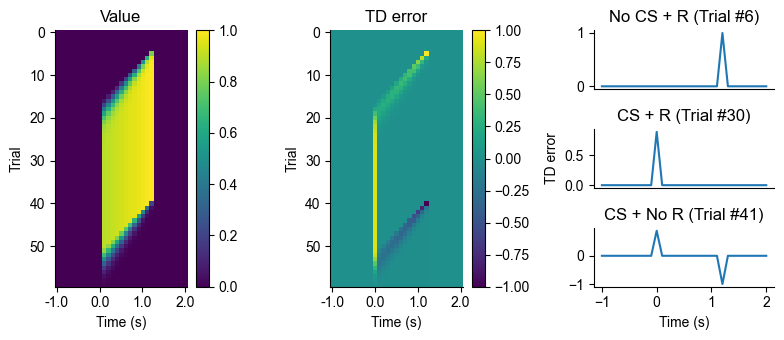

In [7]:
figure(figsize=(8, 3.5))

subplot2grid((3,3), (0,0), rowspan=3)
imshow(value); colorbar()
title("Value"); ylabel("Trial"); xlabel("Time (s)"); xticks(0:Int(1/dt):nt, -1:1:T-1)

subplot2grid((3,3), (0,1), rowspan=3)
imshow(δ); colorbar()
title("TD error"); ylabel("Trial"); xlabel("Time (s)"); xticks(0:Int(1/dt):nt, -1:1:T-1)

subplot2grid((3,3), (0,2))
plot(-1:0.1:2, δ[6, :]); title("No CS + R (Trial #6)"); xticks([])

subplot2grid((3,3), (1,2))
plot(-1:0.1:2, δ[30, :]); title("CS + R (Trial #30)"); ylabel("TD error"); xticks([])

subplot2grid((3,3), (2,2))
plot(-1:0.1:2, δ[41, :]); title("CS + No R (Trial #41)"); xlabel("Time (s)")

tight_layout()

CSは条件刺激(conditioned stimulus), Rは報酬(reward)を意味する．

この際にprediction error信号の時間的変位(temporal shift)が観察されるが，

- A gradual temporal shift of dopamine responses mirrors the progression of temporal difference error in machine learning
https://www.nature.com/articles/s41593-022-01109-2


Rescorla–Wagner model